# Advanced Exercises Solutions

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy.wcs import WCS
from astroquery.vizier import Vizier

from astropy.table import Table
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astropy import units as u
from glob import glob
from scipy import interpolate

from scipy.stats import linregress

Text(0, 0.5, 'F$_{\\lambda}$')

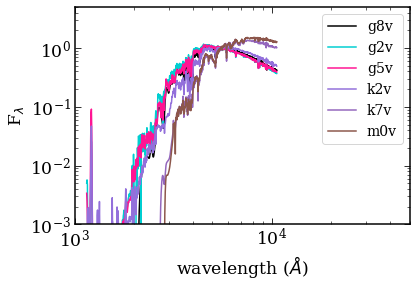

In [33]:
# Open the templates & plot

def stellar_colors(stellartype):
    template = Table.read('pickles_stellartemps/' + str(stellartype) + '.dat.txt', format='ascii', header_start=1, delimiter="|", data_start=3, data_end=1893
                    )
    wave = np.array(template['lambda'], dtype='float')
    nflam = np.array(template['nflam'], dtype='float')

    return wave, nflam


stellar_types = glob('pickles_stellartemps/*.txt')

stellar_library = {}

for s in stellar_types:
    star_type = s.split('temps/')[1].split('.dat')[0]
    wave, nflam = stellar_colors(star_type)
    stellar_library[star_type] = {'wave': wave, 'spectrum': nflam}

for s in stellar_library.keys():
    plt.loglog(stellar_library[s]['wave'], stellar_library[s]['spectrum'], label=s)
plt.legend(fontsize=14)
plt.xlim(1e3, 5e4)
plt.ylim(1e-3, 5e0)

plt.xlabel('wavelength ($\AA$)')
plt.ylabel('F$_{\lambda}$')



Text(0, 0.5, 'transmission')

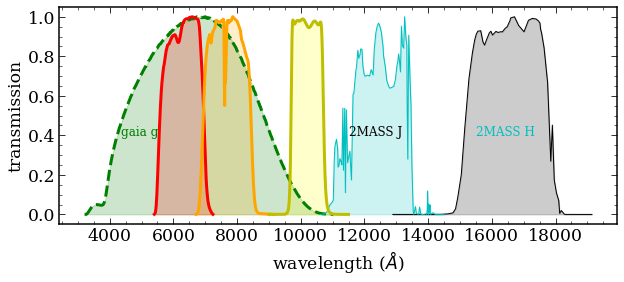

In [48]:
# Load transmission curves, example solutions

gaia_g_passband = Table.read('GAIA_GAIA0.G.dat', format='ascii')
wave_g = gaia_g_passband['col1']
trans_g = gaia_g_passband['col2']

hband_2mass_wave, hband_2mass_trans = np.genfromtxt('2MASS_2MASS.H.dat').T
jband_2mass_wave, jband_2mass_trans = np.genfromtxt('2MASS_2MASS.J.dat').T

subaru_b_wave, subaru_b_trans = np.genfromtxt('subaru_b.txt').T
subaru_r_wave, subaru_r_trans = np.genfromtxt('subaru_r.txt').T
subaru_i_wave, subaru_i_trans = np.genfromtxt('subaru_i.txt').T
subaru_y_wave, subaru_y_trans = np.genfromtxt('subaru_y.txt').T
subaru_z_wave, subaru_z_trans = np.genfromtxt('subaru_z.txt').T

hst_f160w_wave, hst_f160w_trans = np.genfromtxt('F160W_IR_throughput.csv', delimiter=',').T[1:]
hst_f125w_wave, hst_f125w_trans = np.genfromtxt('F125W_IR_throughput.csv', delimiter=',').T[1:]

fig = plt.figure(figsize=(10, 4))
plt.plot(wave_g, trans_g, '--g', linewidth=3, label='Gaia g passband',)
plt.fill_between(wave_g, trans_g, alpha=0.2, color='g')
plt.text(4350, 0.4, 'gaia g', color='green', fontsize=12)

plt.plot(hband_2mass_wave, hband_2mass_trans, '-k', linewidth=1, label='2MASS H',)
plt.fill_between(hband_2mass_wave, hband_2mass_trans, color='k', alpha=0.2)
plt.text(11500, 0.4, '2MASS J', color='k', fontsize=12)

plt.plot(jband_2mass_wave, jband_2mass_trans, '-c', linewidth=1, label='2MASS J',)
plt.fill_between(jband_2mass_wave, jband_2mass_trans, color='c',  alpha=0.2)
plt.text(15500, 0.4, '2MASS H', color='c', fontsize=12)

plt.plot(subaru_r_wave, subaru_r_trans, '-r', linewidth=3)
plt.fill_between(subaru_r_wave, subaru_r_trans, color='r', alpha=0.2)

plt.plot(subaru_i_wave, subaru_i_trans, '-', color='orange', linewidth=3)
plt.fill_between(subaru_i_wave, subaru_i_trans, color='orange', alpha=0.2)


plt.plot(subaru_y_wave, subaru_y_trans, '-y', linewidth=3)
plt.fill_between(subaru_y_wave, subaru_y_trans, color='yellow', alpha=0.2)

plt.xlabel('wavelength ($\AA$)')
plt.ylabel('transmission')


Text(0, 0.5, 'F$_{\\lambda}$')

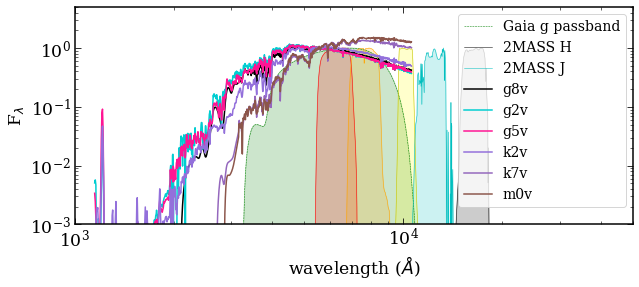

In [37]:
fig = plt.figure(figsize=(10, 4))
plt.plot(wave_g, trans_g, '--g', linewidth=0.5, label='Gaia g passband',)
plt.fill_between(wave_g, trans_g, alpha=0.2, color='g')

plt.plot(hband_2mass_wave, hband_2mass_trans, '-k', linewidth=0.5, label='2MASS H',)
plt.fill_between(hband_2mass_wave, hband_2mass_trans, color='k', alpha=0.2)

plt.plot(jband_2mass_wave, jband_2mass_trans, '-c', linewidth=0.5, label='2MASS J',)
plt.fill_between(jband_2mass_wave, jband_2mass_trans, color='c',  alpha=0.2)

plt.plot(subaru_r_wave, subaru_r_trans, '-r', linewidth=0.5)
plt.fill_between(subaru_r_wave, subaru_r_trans, color='r', alpha=0.2)

plt.plot(subaru_i_wave, subaru_i_trans, '-', color='orange', linewidth=0.5)
plt.fill_between(subaru_i_wave, subaru_i_trans, color='orange', alpha=0.2)


plt.plot(subaru_y_wave, subaru_y_trans, '-y', linewidth=0.5)
plt.fill_between(subaru_y_wave, subaru_y_trans, color='yellow', alpha=0.2)


for s in stellar_library.keys():
    plt.loglog(stellar_library[s]['wave'], stellar_library[s]['spectrum'], label=s)
plt.legend(fontsize=14)
plt.xlim(1e3, 5e4)
plt.ylim(1e-3, 5e0)

plt.xlabel('wavelength ($\AA$)')
plt.ylabel('F$_{\lambda}$')

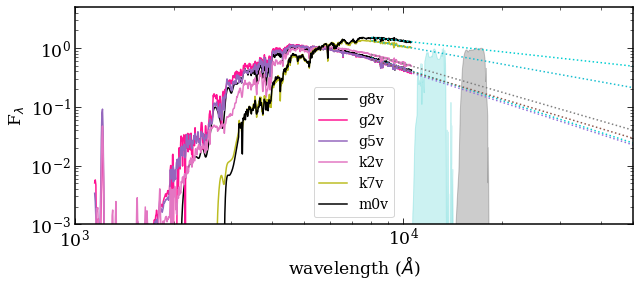

In [45]:
# log-linear extrapolation of RJ tail

new_array = np.linspace(8e3, 1e5, 1000)

for s in stellar_library.keys():
    extrap_wave = np.where(stellar_library[s]['wave']>8e3)
    extrap_nflam = stellar_library[s]['spectrum'][extrap_wave]
    regression = linregress(np.log(stellar_library[s]['wave'][extrap_wave]),
                           np.log(extrap_nflam))
    
    power_law = np.exp(regression.intercept + regression.slope * np.log(new_array))
    stellar_library[s]['power law'] = power_law
    


fig = plt.figure(figsize=(10, 4))
for s in stellar_library.keys():
    plt.loglog(stellar_library[s]['wave'], stellar_library[s]['spectrum'], label=s)
    plt.loglog(new_array, stellar_library[s]['power law'], ':')
    
plt.legend(fontsize=14)
plt.xlim(1e3, 5e4)
plt.ylim(1e-3, 5e0)

plt.xlabel('wavelength ($\AA$)')
plt.ylabel('F$_{\lambda}$')

plt.fill_between(hband_2mass_wave, hband_2mass_trans, color='k', alpha=0.2)
plt.fill_between(jband_2mass_wave, jband_2mass_trans, color='c', alpha=0.2)

In [46]:
# photometry calculator

def AB_mags(spectrum_wave, spectrum_flux, filter_wave, transmission, fnu=True):
    filter_wave = filter_wave[1:]
    transmission = transmission[1:]
    
    phot_filter = interpolate.interp1d(filter_wave, transmission)
    
    limits = np.where((spectrum_wave<=max(filter_wave))\
                        &(spectrum_wave>=min(filter_wave)))
    
    wave_filter = spectrum_wave[limits]
    
    flux_filter = spectrum_flux[limits]
    
    filter_response = []
     
    for angstrom in wave_filter:
        new_value = angstrom
        new_trans = phot_filter(new_value)
        filter_response.append(new_trans)
        
    # Calculate <F_lambda>
    # assuming input wavelength is in Angstrom and input flux is in Fnu; need to convert to Flambda
    c = 3.0e18
    
    if fnu:
        Flambda = c / wave_filter**2 * flux_filter
    else:
        Flambda = flux_filter
        
    integrand_bottom = wave_filter * filter_response
    integrand_top = integrand_bottom * Flambda
    
    average_flux_lambda = np.trapz(integrand_top, wave_filter) / np.trapz(integrand_bottom, wave_filter)
    
    #Tokunaga+Vacca05 Eqn. A11 --> calculate pivot wavelength to convert <Flambda> to <Fnu>
    lambda_pivot_integrand_top = wave_filter * filter_response
    lambda_pivot_integrand_bottom = filter_response / wave_filter
    lambda_pivot2 = np.trapz(lambda_pivot_integrand_top, wave_filter) / np.trapz(lambda_pivot_integrand_bottom, wave_filter)
    
    average_flux_nu = 1e23 * lambda_pivot2 / c * average_flux_lambda # in units of Jy
    
    #convert back to F_nu to get to magnitude, since we did this in F_lambda
    
    m = -2.5 * np.log10(average_flux_nu/3631)
    
    return m, average_flux_nu, np.sqrt(lambda_pivot2)

-0.10696173455316671 0.40038631343322884 0.16446715079346452 0.6216649560429373 0.5411242155772351
4006.9225012797274 2511.1446115408235 3120.60922926791 2048.1429574503995 2205.852976549038


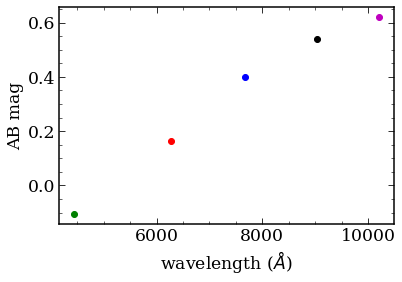

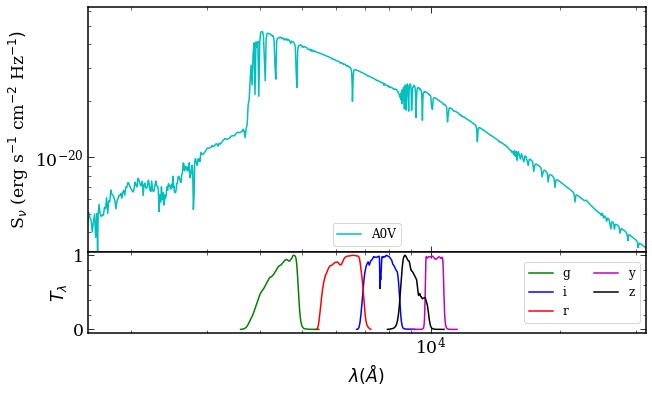

In [66]:
# Vega spectrum

angstrom, flux_nu = np.genfromtxt('A0Vspec.txt').T

# just shortening variable names for convenience, this is redundant
b_l, b_t = subaru_b_wave, subaru_b_trans
i_l, i_t = subaru_i_wave, subaru_i_trans
r_l, r_t = subaru_r_wave, subaru_r_trans
y_l, y_t = subaru_y_wave, subaru_y_trans
z_l, z_t = subaru_z_wave, subaru_z_trans

b = AB_mags(angstrom, flux_nu, b_l, b_t)
i = AB_mags(angstrom, flux_nu, i_l, i_t)
r = AB_mags(angstrom, flux_nu, r_l, r_t)
y = AB_mags(angstrom, flux_nu, y_l, y_t)
z = AB_mags(angstrom, flux_nu, z_l, z_t)

print(b[0], i[0], r[0], y[0], z[0])
print(b[1], i[1], r[1], y[1], z[1])

plt.plot(b[2], b[0], 'og')
plt.plot(i[2], i[0], 'ob')
plt.plot(r[2], r[0], 'or')
plt.plot(y[2], y[0], 'om')
plt.plot(z[2], z[0], 'ok')
plt.xlabel("wavelength ($\AA$)")
plt.ylabel("AB mag")
plt.show()

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw = {'height_ratios':[3,1]}, sharex=True)
ax1.loglog(np.median(b_l), b[1], 'og', markersize=10)
ax1.loglog(np.median(i_l), i[1], 'ob', markersize=10)
ax1.loglog(np.median(r_l), r[1], 'or', markersize=10)
ax1.loglog(np.median(y_l), y[1], 'om', markersize=10)
ax1.loglog(np.median(z_l), z[1], 'ok', markersize=10)
ax1.loglog(angstrom, flux_nu, 'c-',label='A0V')
f.subplots_adjust(hspace=0)
ax1.legend(loc=8, ncol=2, fontsize=12)
ax1.set_xlim((10**3.2, 10**4.5))
ax1.set_ylim(10**(-20.5), 10**(-19.2))
ax2.set_xlim((10**3.2, 10**4.5))
ax1.set_ylabel(r"S$_{\nu}$ (erg s$^{-1}$ cm$^{-2}$ Hz$^{-1})$")

ax2.plot(b_l, b_t, '-g', label='g')
ax2.plot(i_l, i_t, '-b',label='i')
ax2.plot(r_l, r_t, '-r', label='r')
ax2.plot(y_l, y_t, '-m',label='y')
ax2.plot(z_l, z_t, '-k',label='z')
ax2.legend(loc=7, ncol=2, fontsize=12)
ax2.set_xlabel("$\lambda (\AA)$")
ax2.set_ylabel('$T_{\lambda}$')
plt.show()

In [69]:
# Table of photometry

stellar_table = Table(names=['spectral type', 'g', 'b', 'i', 'J', 'H'],
                      dtype=('S3', 'float', 'float', 'float', 'float', 'float'))

for s in stellar_library.keys():
    wave = stellar_library[s]['wave']
    spec = stellar_library[s]['spectrum']
    gmag, _, _ = AB_mags(wave, spec, wave_g, trans_g, fnu=False)
    bmag, _, _ = AB_mags(wave, spec, b_l, b_t, fnu=False)
    imag, _, _ = AB_mags(wave, spec, i_l, i_t, fnu=False)
    
    wave_extrap = new_array
    spec_extrap = stellar_library[s]['power law']
    hmag, _, _ = AB_mags(wave_extrap, spec_extrap, hband_2mass_wave, hband_2mass_trans, fnu=False)
    jmag, _, _ = AB_mags(wave_extrap, spec_extrap, jband_2mass_wave, jband_2mass_trans, fnu=False)
    
    ROW = [s, gmag, bmag, imag, hmag, jmag]
    stellar_table.add_row(ROW)
    
stellar_table
    

spectral type,g,b,i,J,H
bytes3,float64,float64,float64,float64,float64
g8v,-21.238869583533173,-20.54161898376922,-21.48048711394363,-21.646753297677577,-21.589875185343267
g2v,-21.20925729862075,-20.651886917165218,-21.409052094730463,-21.56847733508188,-21.512366173870475
g5v,-21.212211018955962,-20.604009286807617,-21.421731929182943,-21.685028629394935,-21.58622780360524
k2v,-21.310654308838366,-20.380561876586704,-21.6073342785011,-21.951703394012938,-21.833372367771094
k7v,-21.629426804423545,-19.915316266275898,-22.114762505363675,-23.019665374447577,-22.710801490029013
m0v,-21.71559480610307,-19.96401494568869,-22.226492659080265,-23.461552415535735,-23.031722943518616


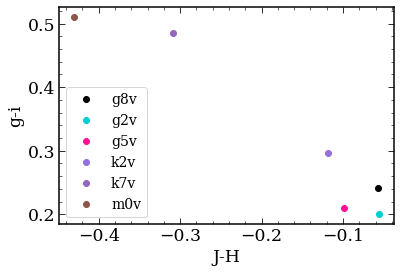

In [74]:
# Plot colors

[plt.plot(stellar_table['J'][i]-stellar_table['H'][i], stellar_table['g'][i]-stellar_table['i'][i],\
          'o', label=stellar_table['spectral type'][i]) for i in range(len(stellar_table))]

plt.xlabel('J-H')
plt.ylabel('g-i')
plt.legend(fontsize=14, loc=3)